In [1]:
# Source: https://www.kaggle.com/code/mtszkw/xgboost-for-stock-trend-prices-prediction

In [2]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import json
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
#!py -m pip install stldecompose
#from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

pio.renderers.default='iframe'

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
# init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [3]:
import yfinance as yf  # for downloading stock data
from pandas.api.types import is_numeric_dtype
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

dataframe = yf.download("INTC", period="max")
#print ("shape = ", dataframe.shape)
#print(dataframe.head())

# we don't need Adj Close column
dataframe = dataframe.drop(columns=['Adj Close'])

# eliminate data before 2015
dataframe['Date'] = pd.to_datetime(dataframe.index)
dataframe = dataframe[(dataframe['Date'].dt.year >= 2015)].copy()
dataframe = dataframe.set_index('Date')

# In addition to the index column called 'Date', keep a new column called Date for future use
dataframe['Date'] = pd.to_datetime(dataframe.index)

print ("shape = ", dataframe.shape)
print(dataframe.head())

[*********************100%%**********************]  1 of 1 completed

shape =  (2412, 6)
                 Open       High        Low      Close    Volume       Date
Date                                                                       
2015-01-02  36.669998  37.160000  36.110001  36.360001  23605600 2015-01-02
2015-01-05  36.200001  36.450001  35.939999  35.950001  32785000 2015-01-05
2015-01-06  36.080002  36.230000  35.259998  35.279999  30847600 2015-01-06
2015-01-07  35.639999  36.070000  35.270000  36.020000  27725200 2015-01-07
2015-01-08  36.369999  37.000000  36.259998  36.689999  31765400 2015-01-08


In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=dataframe.index,
                      open=dataframe.Open,
                      high=dataframe.High,
                      low=dataframe.Low,
                      close=dataframe.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=dataframe.index, y=dataframe.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

<Figure size 640x480 with 0 Axes>

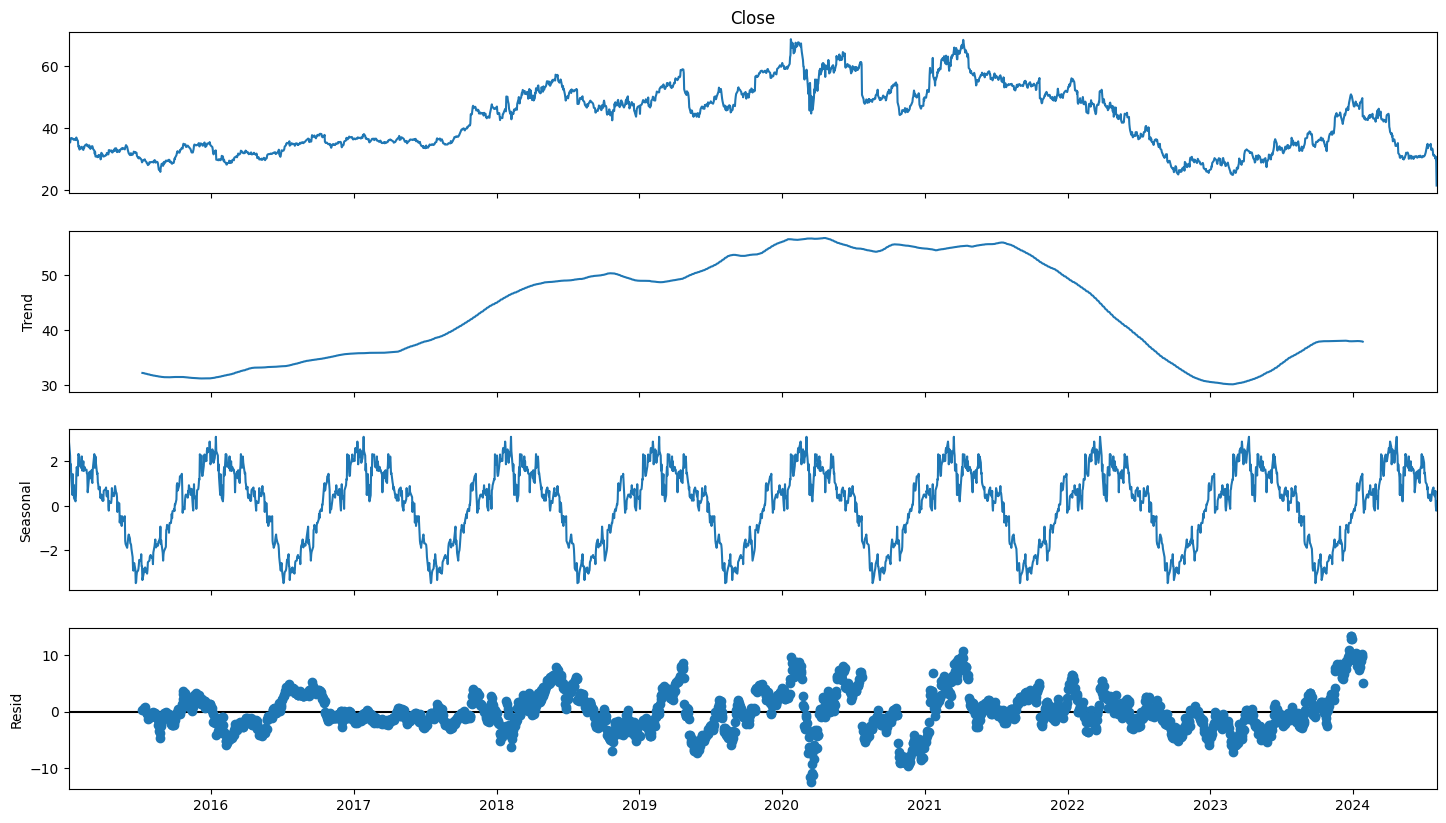

In [5]:
#plot the seasonality 
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(x=dataframe['Close'], model='additive', filt=None, period=5*52)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()

In [6]:
# COMPUTE TECHNICAL INDICATORS

In [7]:
# Moving Averages
dataframe['EMA_9'] = dataframe['Close'].ewm(9).mean().shift()
dataframe['SMA_5'] = dataframe['Close'].rolling(5).mean().shift()
dataframe['SMA_10'] = dataframe['Close'].rolling(10).mean().shift()
dataframe['SMA_15'] = dataframe['Close'].rolling(15).mean().shift()
dataframe['SMA_30'] = dataframe['Close'].rolling(30).mean().shift()

# SMA and EMA columns will be NaN for the first few rows
dataframe.dropna(inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.Close, name='Close', opacity=0.2))
fig.show()

In [8]:
#Relative Strength Index

def relative_strength_idx(dataframe, n=14):
    close = dataframe['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

dataframe['RSI'] = relative_strength_idx(dataframe).fillna(0)

fig = go.Figure(go.Scatter(x=dataframe.Date, y=dataframe.RSI, name='RSI'))
fig.show()

In [9]:
#MACD 

EMA_12 = pd.Series(dataframe['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(dataframe['Close'].ewm(span=26, min_periods=26).mean())
dataframe['MACD'] = pd.Series(EMA_12 - EMA_26)
dataframe['MACD_signal'] = pd.Series(dataframe.MACD.ewm(span=9, min_periods=9).mean())

# MACD columns will be NaN for the first few rows
dataframe.dropna(inplace=True)

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [10]:
# Stochastic Oscillator
# Calculates Stochastic Oscillator (%K and %D) for a given window size
k=14
d=3

low_min = dataframe['Low'].rolling(window=k).min()
high_max = dataframe['High'].rolling(window=k).max()
dataframe['STOCHASTIC_OSCILLATOR_K_PERCENT'] = 100 * (dataframe['Close'] - low_min) / (high_max - low_min)

# Calculate %D (3-period moving average of %K)
dataframe['STOCHASTIC_OSCILLATOR_D_PERCENT'] = dataframe['STOCHASTIC_OSCILLATOR_K_PERCENT'].rolling(window=d).mean()  

# Stochastic columns will be NaN for the first few rows
dataframe.dropna(inplace=True)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe['STOCHASTIC_OSCILLATOR_K_PERCENT'], name='STOCHASTIC_OSCILLATOR_K_PERCENT'), row=1, col=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe['STOCHASTIC_OSCILLATOR_D_PERCENT'], name='STOCHASTIC_OSCILLATOR_D_PERCENT'), row=1, col=1)
fig.show()

In [11]:
# Bollinger Bands

# Calculates technical indicators based on the provided window size
dataframe['BOLLINGER_UPPER'] = dataframe['SMA_10'] + (2 * dataframe['Close'].rolling(window=10).std())
dataframe['BOLLINGER_LOWER'] = dataframe['SMA_10'] - (2 * dataframe['Close'].rolling(window=10).std())

# Bollinger band columns will be NaN for the first few rows
dataframe.dropna(inplace=True)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe['BOLLINGER_UPPER'], name='BOLLINGER_UPPER'), row=1, col=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe['BOLLINGER_LOWER'], name='BOLLINGER_LOWER', fill='tonexty'), row=1, col=1)
fig.show()

In [12]:
print ("NaN values: ", dataframe.isna().sum())
print (dataframe.head())

NaN values:  Open                               0
High                               0
Low                                0
Close                              0
Volume                             0
Date                               0
EMA_9                              0
SMA_5                              0
SMA_10                             0
SMA_15                             0
SMA_30                             0
RSI                                0
MACD                               0
MACD_signal                        0
STOCHASTIC_OSCILLATOR_K_PERCENT    0
STOCHASTIC_OSCILLATOR_D_PERCENT    0
BOLLINGER_UPPER                    0
BOLLINGER_LOWER                    0
dtype: int64
                 Open       High    Low      Close    Volume       Date  \
Date                                                                      
2015-05-08  32.509998  32.880001  32.34  32.799999  26926500 2015-05-08   
2015-05-11  32.680000  32.709999  32.43  32.689999  18358600 2015-05-11   
2015-05-

In [13]:
#Shift label column
# Because I want to predict the next day price, after calculating all features for day  Di, I shift Close price column by -1 rows. 
# After doing that, for day  Di we have features from the same timestamp e.g.  RSIi, but the price  Ci+1 from upcoming day.

dataframe['Close'] = dataframe['Close'].shift(-1)

In [14]:
#Drop invalid samples¶
# Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated  SMA10 for the first 10 days. 
# Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

dataframe = dataframe.iloc[33:] # Because of moving averages and MACD line
dataframe = dataframe[:-1]      # Because of shifting close price

dataframe.index = range(len(dataframe))

In [15]:
# Here I split stock data frame into three subsets: training ( 70%), validation ( 15%) and test ( 15%) sets. 
# I calculated split indices and create three separate frames (train_dataframe, valid_dataframe, test_dataframe). All three frames have been ploted in the chart below.
             
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(dataframe.shape[0] * (1-test_size))
valid_split_idx = int(dataframe.shape[0] * (1-(valid_size+test_size)))

train_dataframe  = dataframe.loc[:valid_split_idx].copy()
valid_dataframe  = dataframe.loc[valid_split_idx+1:test_split_idx].copy()
test_dataframe   = dataframe.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_dataframe.Date, y=train_dataframe.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_dataframe.Date, y=valid_dataframe.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_dataframe.Date,  y=test_dataframe.Close,  name='Test'))
fig.show()

In [16]:
# Drop unnecessary columns

drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']

train_dataframe = train_dataframe.drop(drop_cols, axis=1)
valid_dataframe = valid_dataframe.drop(drop_cols, axis=1)
test_dataframe  = test_dataframe.drop(drop_cols, axis=1)

In [17]:
# split into features and labels

y_train = train_dataframe['Close'].copy()
X_train = train_dataframe.drop(['Close'], axis=1)

y_valid = valid_dataframe['Close'].copy()
X_valid = valid_dataframe.drop(['Close'], axis=1)

y_test  = test_dataframe['Close'].copy()
X_test  = test_dataframe.drop(['Close'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   EMA_9                            1604 non-null   float64
 1   SMA_5                            1604 non-null   float64
 2   SMA_10                           1604 non-null   float64
 3   SMA_15                           1604 non-null   float64
 4   SMA_30                           1604 non-null   float64
 5   RSI                              1604 non-null   float64
 6   MACD                             1604 non-null   float64
 7   MACD_signal                      1604 non-null   float64
 8   STOCHASTIC_OSCILLATOR_K_PERCENT  1604 non-null   float64
 9   STOCHASTIC_OSCILLATOR_D_PERCENT  1604 non-null   float64
 10  BOLLINGER_UPPER                  1604 non-null   float64
 11  BOLLINGER_LOWER                  1604 non-null   float64
dtypes: float64(12)
memor

In [18]:
%%time

# finetune XGBoostRegressor

import warnings
warnings.filterwarnings("ignore")

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42],
    'booster':['gbtree'],
    'base_score':[0.5],
    'importance_type':['gain'],
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'base_score': 0.5, 'booster': 'gbtree', 'gamma': 0.01, 'importance_type': 'gain', 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Best validation score = 0.5024852569098517
CPU times: total: 1h 43min 16s
Wall time: 5min 42s


In [19]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
print (model.get_xgb_params())
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': None, 'gamma': 0.01, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
CPU times: total: 5.78 s
Wall time: 318 ms


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

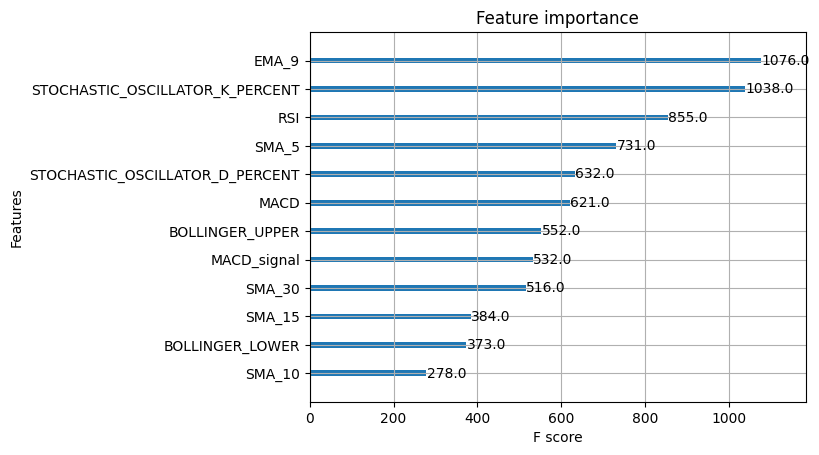

In [20]:
plot_importance(model);

In [21]:
# calculate and visualize predictions

y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [29.03000069 29.36000061 29.18000031 29.29000092 31.52000046]
y_pred = [28.131847 28.564072 28.880754 28.907516 28.931288]


In [22]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 3.0132053311535008


In [23]:
predicted_prices = dataframe.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=dataframe.Date, y=dataframe.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()